In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm

#### Binomial data 

Suppose we have n trials and each one can result in one of the two states: success or failure. We are interested in the probability of success, modeled by $\theta$. 

The likelihood model: <br><br>
p(y|$\theta$) = Bin(y|n, $\theta$) = ${N}\choose{y}$$\theta^{y}(1-\theta)^{n-y}$. 

Putting as prior for $\theta$: $p(\theta)$ = Beta$(\theta|a, b)$. <br><br>
We have posterior:
$p(\theta|y)$ = Beta($\theta$|a + y, b + n - y)

In [3]:
y = np.array([7])
n = np.array([10])

with pm.Model() as binomial_model:
    theta = pm.Beta('theta', 1, 1)
    y_observed = pm.Binomial('y', p=theta, n=n, observed=y)
    trace = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]
Sampling 4 chains: 100%|██████████| 6000/6000 [00:01<00:00, 5020.35draws/s]


We should expect posterior equal to Beta($\theta$|8, 4), which by property of Beta distribution provides:
- E($p(\theta|y)$) = $\frac{8}{12}$ = 0.75 <br>
- Var($p(\theta|y)$) = 0.017
- sd($p(\theta|y)$) = 0.13

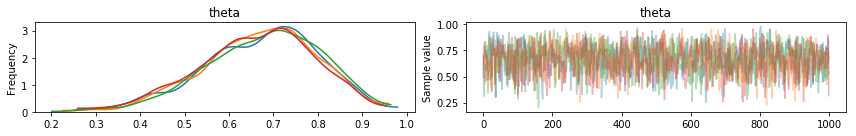

In [4]:
pm.traceplot(trace);

In [5]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
theta,0.669018,0.128427,0.003008,0.411181,0.896571,1680.181739,1.001439


In [6]:
# we can also use Bernoulli distribution
y = np.array([1] * 7 + [0] * 3)
with pm.Model() as bernoulli_model:
    theta = pm.Beta('theta', 1, 1)
    y_observed = pm.Bernoulli('y', p=theta, observed=y)
    trace = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]
Sampling 4 chains: 100%|██████████| 6000/6000 [00:01<00:00, 4955.66draws/s]
The acceptance probability does not match the target. It is 0.8835458030725846, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8865202456434841, but should be close to 0.8. Try to increase the number of tuning steps.


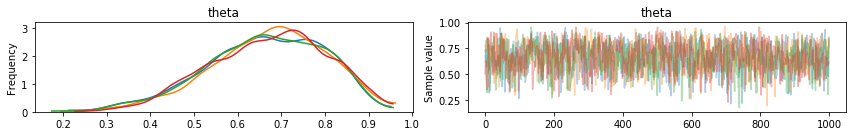

In [7]:
pm.traceplot(trace);

In [8]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
theta,0.665128,0.133071,0.00361,0.418126,0.909535,1559.523527,1.000518


We might be interested in posterior predictive distribution. <br>
p($\tilde{y}$ = 1|y) = $\int_{0}^{1}$p($\tilde{y}$ = 1|$\theta$)p($\theta$|y)d$\theta$ = $\int_{0}^{1}$$\theta$p($\theta$|y)d$\theta$ = $\int_{0}^{1}$$\theta$Beta($\theta$|a + y, b + n - y)d$\theta$ = E(p($\theta$|y)) = $\frac{a + y}{a + b + n}$

In our case: p($\tilde{y}$ = 1|y) = $\frac{1 + 7}{1 + 1 + 10}$ = $\frac{8}{12}$ = 0.75

In [9]:
y_pred = pm.sample_posterior_predictive(
    trace, 
    samples=500,
    model=bernoulli_model
)

100%|██████████| 500/500 [00:00<00:00, 3550.11it/s]


In [10]:
type(y_pred)

dict

In [11]:
y_pred.keys()

dict_keys(['y'])

In [12]:
y_pred['y']

array([[1, 1, 1, ..., 0, 0, 1],
       [1, 1, 1, ..., 0, 1, 0],
       [0, 0, 1, ..., 1, 0, 0],
       ...,
       [1, 1, 0, ..., 1, 1, 1],
       [1, 0, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]])

In [13]:
y_pred['y'].shape

(500, 10)

In [14]:
y_pred['y'].mean()

0.6652

#### Normal distribution with known variance 
Assume p(y|$\theta$) = N(y|$\theta$, $\sigma^{2}$), where $\sigma$ is known. 

Model prior as: <br>
p($\theta$) = N($\theta$|$\mu_{0}$, $\tau_{0}^{2}$), where parameters are known numbers. 

Posterior distribution for n independent sample: <br>
p($\theta$| y) = N($\theta$|$\mu_{0}$, $\tau_{0}$)$\prod_{i=1}^{n}$N(y|$\theta$, $\sigma^{2}$), 

After tedious algebraic manipulations: 
p($\theta$| y) = N($\theta$|$\mu_{n}$, $\tau_{n}^{2}$)


$\mu_{n}$ = $\frac{\frac{\mu_{0}}{\tau_{0}^{2}} + \frac{n}{\sigma^{2}}\bar{y}}{\frac{1}{\tau_{0}^{2}} + \frac{n}{\sigma^{2}}}$ <br><br>
$\frac{1}{\tau_{n}^{2}}$ = $\frac{1}{\tau_{0}^{2}}$ + $\frac{n}{\sigma^{2}}$

In [15]:
sigma = 2
y = sigma * np.random.randn(100)

with pm.Model() as model_known_sigma:
    # theta on purpose is not centered at 0
    theta = pm.Normal('theta', mu=1, sd=1) 
    y_observed = pm.Normal('y', mu=theta, sd=sigma, observed=y)
    trace = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]
Sampling 4 chains: 100%|██████████| 6000/6000 [00:01<00:00, 5216.26draws/s]
The acceptance probability does not match the target. It is 0.8834319390850673, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8900905102897547, but should be close to 0.8. Try to increase the number of tuning steps.


In [16]:
y_mean = np.mean(y)
y_mean

-0.12414238556089532

In [17]:
# we should expect (posterior of theta)
y_mean_posterior = (1/1 + len(y)/sigma**2 * y_mean) / (1/1 + len(y) / sigma**2)
y_std_posterior = np.sqrt(1 / (1/1 + len(y) / sigma ** 2))

In [18]:
y_mean_posterior, y_std_posterior

(-0.08090613996239936, 0.19611613513818404)

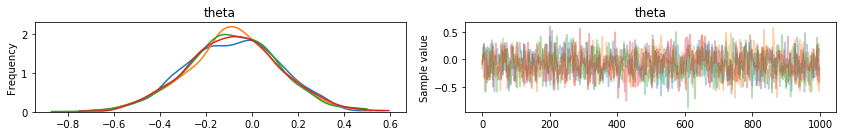

In [19]:
pm.traceplot(trace);

In [20]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
theta,-0.083496,0.198187,0.005159,-0.46993,0.311555,1550.815816,0.999622


In [21]:
y_pred = pm.sample_posterior_predictive(
    trace, 
    model=model_known_sigma
)

100%|██████████| 4000/4000 [00:01<00:00, 3481.66it/s]


In [22]:
y_pred['y'].shape

(4000, 100)

#### Normal distribution with known mean but unknown variance

Assume p(y|$\theta$) = N(y|$\theta$, $\sigma^{2}$), where $\theta$ is known.


p(y|$\theta$) = $\prod_{i=1}^{n}$$\frac{1}{\sqrt{2\pi\sigma^{2}}}$$e^{-\frac{(y_{i} - \theta)^{2}}{2\sigma^{2}}}$ $\propto$ $\sigma^{-n}e^{-\frac{1}{2\sigma^2}\sum_{i=1}^{n}(y_{i}-\theta)^{2}}$ = $\sigma^{-n}e^{-\frac{n}{2\sigma^2}\nu}$ <br><br>$\nu$ is the sufficient statistic
$\nu$ = $\frac{1}{n}\sum_{i=1}^{n}(y_{i} - \theta)^2$

We want a prior distribution for $\sigma^{2}$ which would allow for easy computation of the posterior. Looking at the form of likelihood function, inverse gamma distribution is a good choice: <br><br>
p($\sigma^{2}$) $\propto$ $(\sigma^{2})^{-(\alpha + 1)}$$e^{\frac{\beta}{\sigma^{2}}}$

#### Some recap from distributions 
Let's consider Gamma distribution: <br><br>
p($\theta$|$\alpha$,$\beta$) = Gamma($\theta$|$\alpha$, $\beta$) = $\frac{\beta^{\alpha}}{\Gamma(\alpha)}x^{\alpha-1}e^{-\beta x}$

Gamma distribution models the amount of time we have to wait until $\alpha$ events occur, $\beta$ is the rate of the process. As an example, if we wait for 10 events ($\alpha$=10), and the rate is 2 events per second ($\beta$=2$\frac{1}{s}$), where the unit is arbitrary, we then have expected waiting time E($\theta$) = $\frac{\alpha}{\beta}$ = $\frac{10}{2}$ = 5.

Inverse gamma is modeled as $\frac{1}{\theta}$ $\sim$ Gamma($\theta$|$\alpha$, $\beta$), its mean is equal to $\frac{\beta}{\alpha - 1}$

In [23]:
alpha = 10
beta = 2
theta = np.random.gamma(alpha, 1/beta, size=1000)
inv_theta = 1 / theta

5.0

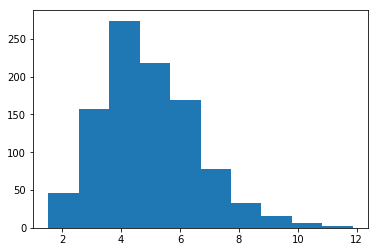

In [24]:
plt.hist(theta);
alpha / beta

0.2222222222222222

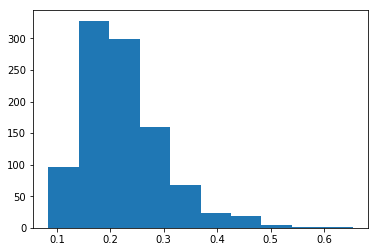

In [25]:
plt.hist(inv_theta);
beta / (alpha - 1)

In bayesian settings it is very convenient to take reparametrized form of Inverse-gamma, which is scaled inverse chi-squared distribution.<br><br>
Inv-${\chi^{2}}$($\nu_{0}$, $\sigma_{0}^{2}$)

If we set prior to such probability, the posterior of $\sigma^{2}$ is the following. <br>

$\sigma^{2}$|y $\sim$ Inv-${\chi^{2}}$($\nu_{0}$ + n, $\frac{\nu_{0}\sigma_{0}^2 + n\nu}{\nu_{0} + n}$)
if n is large enough we can approximate it by Inv-${\chi^{2}}$(n, $\nu$). By inspecting the places in which prior parameters are located we can think of prior distribution as information equivalent to $\nu_{0}$ observations with average squared deviation $\sigma_{0}^{2}$.

Inv-${\chi^{2}}$ is related to Inverse-gamma in the following way: <br><br>
Inv-gamma($\alpha$=$\frac{\nu}{2}$, $\beta$=$\frac{\nu}{2}s^{2}$), if we had Inv-${\chi^{2}}$($\nu$, $s^{2}$)

In [26]:
# some sample from N(0, 4)
y = 2 * np.random.randn(100) 

# suppose we believe to have seen on average 10 observation with
# variance equal to 6
nu_0 = 10
sigma_squared_0 = 6

alpha = nu_0 / 2 
beta = alpha * sigma_squared_0

with pm.Model() as model_known_mu:    
    sigma2 = pm.InverseGamma('sigma^2', alpha=alpha, beta=beta)
    y_observed = pm.Normal('y', mu=0, tau=1/sigma2, observed=y)
    trace = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma^2]
Sampling 4 chains: 100%|██████████| 6000/6000 [00:01<00:00, 4918.82draws/s]


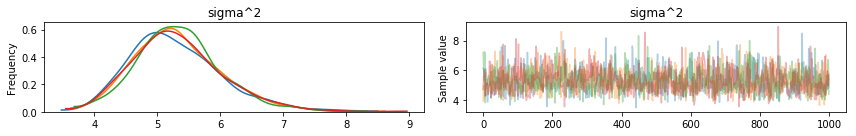

In [27]:
pm.traceplot(trace);

In [28]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
sigma^2,5.315083,0.703316,0.018509,3.966485,6.674986,1344.302869,1.00007


In [29]:
# some sample from N(0, 4)
y = 2 * np.random.randn(100) 

# make the task more difficult!
# suppose we believe to have seen on average 10 observation with
# variance equal to 6
nu_0 = 50
sigma_squared_0 = 6

alpha = nu_0 / 2 
beta = alpha * sigma_squared_0

with pm.Model() as model_known_mu:    
    sigma2 = pm.InverseGamma('sigma^2', alpha=alpha, beta=beta)
    y_observed = pm.Normal('y', mu=0, tau=1/sigma2, observed=y)
    trace = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma^2]
Sampling 4 chains: 100%|██████████| 6000/6000 [00:01<00:00, 4938.53draws/s]


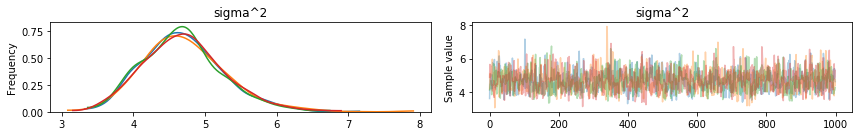

In [30]:
pm.traceplot(trace);

In [31]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
sigma^2,4.695494,0.56269,0.013657,3.572844,5.746529,1621.675466,1.000022


In [32]:
# some sample from N(0, 4)
y = 2 * np.random.randn(100) 

# make the task more easy!
# suppose we believe to have seen on average 10 observation with
# variance equal to 6
nu_0 = 10
sigma_squared_0 = 4.3

alpha = nu_0 / 2 
beta = alpha * sigma_squared_0

with pm.Model() as model_known_mu:    
    sigma2 = pm.InverseGamma('sigma^2', alpha=alpha, beta=beta)
    y_observed = pm.Normal('y', mu=0, tau=1/sigma2, observed=y)
    trace = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma^2]
Sampling 4 chains: 100%|██████████| 6000/6000 [00:01<00:00, 5522.50draws/s]


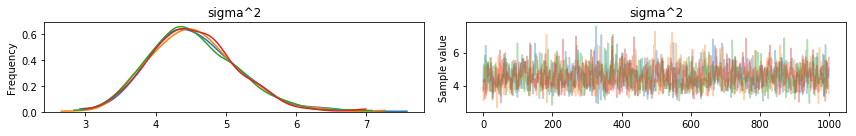

In [33]:
pm.traceplot(trace);

In [34]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
sigma^2,4.544195,0.629342,0.016,3.36175,5.719844,1526.947306,0.999796


In [35]:
# some sample from N(0, 4)
y = 2 * np.random.randn(100) 

# make the prior be equivalent to 1 observation!
# suppose we believe to have seen on average 10 observation with
# variance equal to 6
nu_0 = 1
sigma_squared_0 = 4.3

alpha = nu_0 / 2 
beta = alpha * sigma_squared_0

with pm.Model() as model_known_mu:    
    sigma2 = pm.InverseGamma('sigma^2', alpha=alpha, beta=beta)
    y_observed = pm.Normal('y', mu=0, tau=1/sigma2, observed=y)
    trace = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma^2]
Sampling 4 chains: 100%|██████████| 6000/6000 [00:01<00:00, 5086.41draws/s]


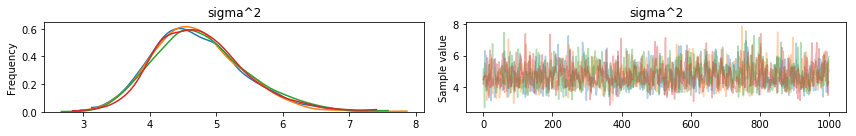

In [36]:
pm.traceplot(trace);

In [37]:
# mean is closer to 4, which represents the process the data was
# generated
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
sigma^2,4.734534,0.676703,0.015688,3.45975,6.043154,1566.339873,1.000729


#### Poisson model 

The likelihood is specified as follows: <br><br>
p(y|$\theta$) = $\frac{\theta^{y}e^{-\theta}}{y!}$

for data $y_{1}$, $y_{2}$, .., $y_{n}$:

p(y|$\theta$) = $\prod_{i=1}^{n}\frac{1}{y_{i}!}\theta^{y_{i}}e^{-\theta}$ $\propto$ $\theta^{\sum_{i=1}^{n}y_{i}}$$e^{-n\theta}$ = $\theta^{t(y)}e^{-n\theta}$

Gamma distribution turns out to be the conjugate prior with: <br><br>
$\theta$|y $\sim$ Gamma($\alpha$ + n$\hat{y}$, $\beta$ + n)

Parameters can by set by trial and error

#### ex. 13

In [38]:
df = pd.DataFrame({
    'year': list(range(1976, 1986)),
    'fatal_accidents': [24, 25, 31, 31, 22, 21, 26, 20, 16, 22],
    'passenger_deaths': [734, 516, 754, 877, 814, 362, 764, 809, 223, 1066],
    'death_rate': [0.19, 0.12, 0.15, 0.16, 0.14, 0.06, 0.13, 0.13, 0.03, 0.15]
})

In [39]:
df

,death_rate,fatal_accidents,passenger_deaths,year
0,0.19,24,734,1976
1,0.12,25,516,1977
2,0.15,31,754,1978
3,0.16,31,877,1979
4,0.14,22,814,1980
5,0.06,21,362,1981
6,0.13,26,764,1982
7,0.13,20,809,1983
8,0.03,16,223,1984
9,0.15,22,1066,1985


In [40]:
# a)
with pm.Model() as model:
    theta = pm.Gamma('theta', mu=25, sd=10)
    y = pm.Poisson('y', mu=theta, observed=df['fatal_accidents'].values)
    trace = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]
Sampling 4 chains: 100%|██████████| 6000/6000 [00:01<00:00, 4675.13draws/s]


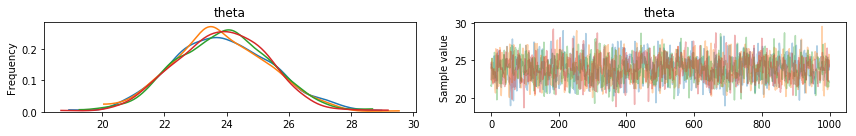

In [41]:
pm.traceplot(trace);

In [42]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
theta,23.845329,1.532004,0.039194,20.924812,26.897875,1732.132121,0.999682


In [43]:
ppc = pm.sample_posterior_predictive(trace, samples=500, model=model)

100%|██████████| 500/500 [00:00<00:00, 3359.30it/s]


In [44]:
ppc['y'].shape

(500, 10)

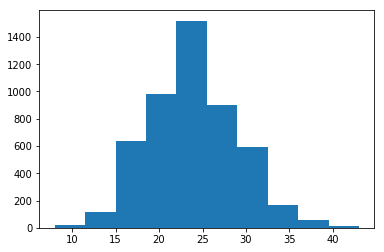

In [45]:
plt.hist(ppc['y'].flatten());

In [46]:
np.percentile(ppc['y'].flatten(), [5, 95])

array([16., 32.])

In [47]:
# b)
df['passenger_miles_flows'] = 100 * 10 ** 6 * df['passenger_deaths'].values / df['death_rate'].values
df

,death_rate,fatal_accidents,passenger_deaths,year,passenger_miles_flows
0,0.19,24,734,1976,3.863158e+11
1,0.12,25,516,1977,4.300000e+11
2,0.15,31,754,1978,5.026667e+11
3,0.16,31,877,1979,5.481250e+11
4,0.14,22,814,1980,5.814286e+11
5,0.06,21,362,1981,6.033333e+11
6,0.13,26,764,1982,5.876923e+11
7,0.13,20,809,1983,6.223077e+11
8,0.03,16,223,1984,7.433333e+11
9,0.15,22,1066,1985,7.106667e+11


In [48]:
mu = 10 ** (-10)
sd = 10 ** (-8)
with pm.Model() as model:
    theta = pm.Gamma('theta', mu=mu, sd=sd)
    ratio = theta * df['passenger_miles_flows'].values
    y = pm.Poisson('y', mu=ratio, observed=df['fatal_accidents'].values)
    trace = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]
Sampling 4 chains: 100%|██████████| 6000/6000 [00:01<00:00, 4555.21draws/s]


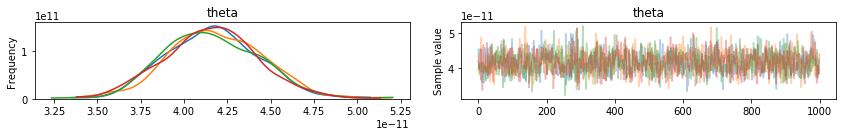

In [49]:
pm.traceplot(trace);

In [50]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
theta,4.165619e-11,2.697103e-12,6.845370e-14,3.675394e-11,4.705449e-11,1650.262021,1.00106


In [51]:
trace['theta'].shape

(4000,)

In [52]:
yp = np.random.poisson(trace['theta'] * 8 * 10 ** 11)

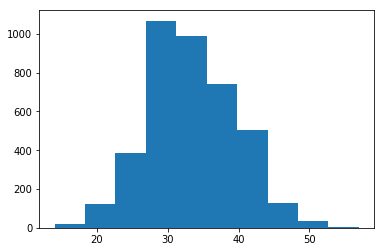

In [53]:
plt.hist(yp);

In [54]:
np.percentile(yp, [5, 95])

array([23., 44.])

In [55]:
# c)
with pm.Model() as model:
    theta = pm.Gamma('theta', mu=500, sd=100)
    y = pm.Poisson('y', mu=theta, observed=df['passenger_deaths'].values)
    trace = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]
Sampling 4 chains: 100%|██████████| 6000/6000 [00:01<00:00, 3538.06draws/s]
The acceptance probability does not match the target. It is 0.8948363905568322, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8939945681955386, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8994121394259168, but should be close to 0.8. Try to increase the number of tuning steps.


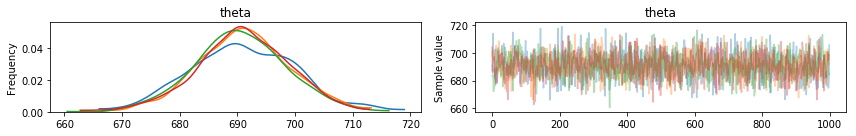

In [56]:
pm.traceplot(trace);

In [57]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
theta,690.790388,8.206275,0.198148,672.902696,705.449958,1608.808305,1.000196


In [58]:
ppc = pm.sample_posterior_predictive(trace, samples=500, model=model)

100%|██████████| 500/500 [00:00<00:00, 3018.44it/s]


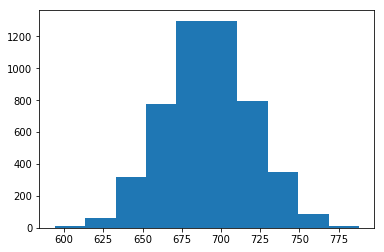

In [59]:
plt.hist(ppc['y'].flatten());

In [60]:
np.percentile(ppc['y'].flatten(), [5, 95])

array([647., 739.])

In [61]:
mu = 10 ** (-11)
sd = 10 ** (-9)
with pm.Model() as model:
    theta = pm.Gamma('theta', mu=mu, sd=sd)
    ratio = theta * df['passenger_miles_flows'].values
    y = pm.Poisson('y', mu=ratio, observed=df['passenger_deaths'].values)
    trace = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]
Sampling 4 chains: 100%|██████████| 8000/8000 [00:02<00:00, 3706.68draws/s]


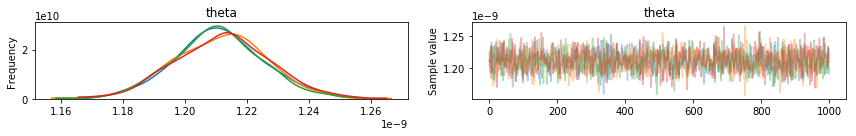

In [62]:
pm.traceplot(trace);

In [63]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
theta,1.210998e-09,1.464021e-11,3.045228e-13,1.182815e-09,1.240693e-09,1730.756347,1.000838


In [64]:
yp = np.random.poisson(trace['theta'] * 8 * 10 ** 11)

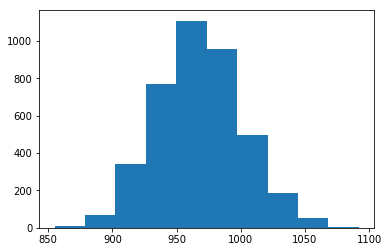

In [65]:
plt.hist(yp);

In [66]:
np.percentile(yp, [5, 95])

array([ 914., 1024.])